моя сеть будет брать на вход батч из n текстов и учиться на каждом тексте последовательно предугадывать каждый следующий токен изходя из соответсвующего префикса

In [54]:
# %pip install tokenizers

In [55]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from tqdm.auto import tqdm as tqdm
from sklearn.model_selection import train_test_split
import nltk

from tokenizers import Tokenizer

import re
from collections import Counter

import numpy as np
import sys

import random
import pickle

In [56]:
device = 'cuda'
torch.cuda.is_available()

True

## загружаю даннытокенайзер, пишу даталодер

In [57]:

with open('../dataset/generated/tokenizer_and_tokenized_dataset/tokenized_texts.pkl', 'rb') as f:
    tokenized_texts = pickle.load(f)

tokenizer = Tokenizer.from_file('../dataset/generated/tokenizer_and_tokenized_dataset/tokenizer_2_vocab_1410_made_on_generated_data')

In [58]:
t2id = tokenizer.get_vocab()
id2t = {i : t for t, i in t2id.items()}
vocab_size = len(t2id.items())
vocab_size

1410

In [59]:
class TextDataset:
  def __init__(self, text):
    self.data = text
    self.unk_id = t2id['<unk>']
    self.bos_id = t2id['<bos>']
    self.eos_id = t2id['<eos>']
    self.pad_id = t2id['<pad>']

  def __getitem__(self, idx):
    token_t = [self.bos_id]
    token_t += [t2id.get(t, self.unk_id) for t in self.data[idx]]
    token_t += [self.eos_id]

    return token_t


  def __len__(self):
    return len(self.data)

In [60]:
def trans_func(input_batch, pad_id=t2id['<pad>']):  # [text, text, ...] -> batch
    '''
    Пример (пусть числа - это номера токенов в словаре):
    input_batch = [
        [t2id['<bos>'], 14, 53, 23, t2id['<eos>']],
        [t2id['<bos>'], 67, 98, t2id['<eos>']],
    ]
    
    фукнция должда вернуть
    batch = {
        'in_ids': [
                    [pad_id ... pad_id, pad_id, pad_id, bos_id],
                    [pad_id ... pad_id, pad_id, bos_id, 14],
                    [pad_id ... pad_id, bos_id, 14,     53 ],
                    [pad_id ... bos_id, 14,     53,     23],

                    [pad_id ... pad_id, pad_id, pad_id, bos_id],
                    [pad_id ... pad_id, pad_id, bos_id, 67],
                    [pad_id ... pad_id, bos_id, 67,     98],

                  ]
        'target_ids': [14, 53, 23, eos_id, 67, 98, eos_id],
    }
    '''
    max_text_len = max(len(text) for text in input_batch)
    seq_cou = sum(len(text) - 1 for text in input_batch)
    
    in_ids = torch.full((seq_cou, max_text_len), pad_id, dtype=torch.long)
    target_ids = torch.empty(seq_cou, dtype=torch.long)

    seq_idx = 0
    for text in input_batch:
        text_tens = torch.tensor(text, dtype=torch.long)
        target_ids[seq_idx: seq_idx + text_tens.shape[0] - 1] = text_tens[1:]
        
        for i in range(1, len(text)):
            in_ids[seq_idx, -i:] = text_tens[:i]
            # target_ids[seq_idx] = text_tens[i]
            seq_idx += 1
        

    batch = {
        'in_ids': in_ids.to(device), 
        'target_ids': target_ids.to(device),
    }
    return batch


# ручками обрезал размер датасета, не забыть об этом 

In [61]:
tokenized_texts = random.sample(tokenized_texts, len(tokenized_texts))

In [62]:
train_t, eval_t = train_test_split(tokenized_texts[:100], test_size=1/4)

In [63]:
train_dataset = TextDataset(train_t)
eval_dataset = TextDataset(eval_t)

In [64]:
train_dataloader = DataLoader(
    dataset=train_dataset, collate_fn=trans_func, batch_size=2,
)

eval_dataloader = DataLoader(
    dataset=eval_dataset, collate_fn=trans_func, batch_size=2,
)



## линейная модель

сделаю линейную модель с переменными гиперпараметрами:

$ hidden\_sizes = [h_1, h_2, ..., h_n], dropouts = [d1, d2, ..., dn], embedding\_dim $

сгенерирую много моделей с разными гиперпараметрами, обучу на x эпохах и выберу лучшую по перплексии

In [65]:
class RNNTensorModel(nn.Module):
    def __init__(self, hidden_sizes, dropout_values, attantion_count, embedding_dim, vocab_size):
        super().__init__()
        self.losses = []
        self.perplexities = []
        
        self.hidden_sizes = hidden_sizes
        self.dropout_values = dropout_values
        self.attention_count = attantion_count
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        
        self.depth = len(hidden_sizes)

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.non_lin = nn.Tanh()
        
        self.rnns = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        self.attentions = nn.ModuleList()
        
        last_size = embedding_dim

        for i in range(self.depth):
            self.linears.append(nn.RNN(last_size, self.hidden_sizes[i], batch_first=True))
            self.dropouts.append(nn.Dropout(p=self.dropout_values[i]))
            last_size =  self.hidden_sizes[i]

        for i in range(self.attention_count):
            self.attentions.append(nn.RNN(last_size, 1, batch_fisrt=True))
        
        self.softmax = nn.Softmax(dim=1)
        
        self.fc = nn.Linear(last_size, vocab_size)

    
    def forward(self, input_batch):
        out = self.embedding(input_batch)  # (batch_size, seq_len, embedding_dim)

        h = None
        for i in range(self.depth):
            out, h = self.rnns[i](out, h)  # (batch_size, seq_len, self.hidden_sizes[i])
            out = self.non_lin(self.dropouts[i](out))  

        weighted_outs = []
        for i in range(self.attention_count):
            weights, _ = self.attentions[i](out)
            weights = self.softmax(weights)
            weighted_outs.append(torch.sum(weights*out, dim=1))
        
        out = sum(weighted_outs) / self.attention_count  # (batch_size, self.hidden_sizes[-1])

        out = self.fc(out)  # (batch_size, vocab_size)
        return out

    def get_sizes(self):
        return {
            'hidden_sizes': self.hidden_sizes,
            'dropout_values': self.dropout_values,
            'embedding_dim': self.embedding_dim, 
            'attention_count': self.attention_count,
            'vocab_size': self.vocab_size, 
            'deepht': self.depht, 
        }

    def get_losses(self):
        return self.losses

    def get_perplexities(self):
        return self.perplexities
    
    
    def __str__(self):
        return f'hs={self.hidden_sizes}, ed={self.embedding_dim}, ac={self.attention_count}'
            
        
        

## evaluate, train

тк я планирю делать сразу много моделей, я сделаю эти методы так, чтобы они работали не на 1 модели, а на списке:

models = [(model1, optimizer1), (model2, optimizer2), ...]

In [66]:
def evaluate(model, optimizer, crit, eval_dataloader):
    model.eval()
    perplexity = []
    amount = 0
    with torch.no_grad():
        for batch in eval_dataloader:
            logs = model(batch['in_ids'])
            len_batch = len(batch['in_ids'])
            for i in range(len_batch):
                loss = crit(
                    logs[i], 
                    batch['target_ids'][i]
                )
                perplexity.append(torch.exp(loss).item())
    rate = sum(perplexity) / len(perplexity)
    return rate


In [67]:
crit_func = nn.CrossEntropyLoss(ignore_index=t2id['<pad>'])

In [68]:
# evaluate(m1, o1, crit, eval_dataloader)

In [69]:
# m1 = LinearTensorModel(hidden_sizes=[64, 64, 64], dropout_values=[0.1, 0.1, 0.1], embedding_dim=128, attantion_count=2, vocab_size=vocab_size)
# m = 
# o1 = torch.optim.Adam(m1.parameters())
# claster = [(m1.to(device), o1)]

### для того, чтобы выбрать лучшую архитектуру, создаю и обучаю на не большой подвыборке кластер с рандомными гиперпараметрами (hidden_dim, hidden_sizes, dropout_values, embedding_dim) на не большом количестве эпох

In [70]:
claster_size = 100 # моделей будет сгенерированно

# hidden_dim_vals = (1, 4)
# hidden_dim_sizes_vals = (4, 64)
# dropout_valuse_vals = (0, 0.2)
# embedding_dim_vals = (30, 300)
# attantion_count_vals = (1, 5)


hidden_dim_vals = (1, 4)
hidden_dim_sizes_vals = (4, 32)
dropout_valuse_vals = (0, 0.2)
embedding_dim_vals = (30, 100)
attantion_count_vals = (1, 5)

claster = []

for i in range(claster_size):
    hidden_dim = random.randint(hidden_dim_vals[0], hidden_dim_vals[1])
    hidden_sizes = random.choices(range(hidden_dim_sizes_vals[0], hidden_dim_sizes_vals[1] + 1), k=hidden_dim)
    dropout_values = np.random.uniform(dropout_valuse_vals[0], dropout_valuse_vals[1], hidden_dim)
    attantion_count = random.randint(attantion_count_vals[0], attantion_count_vals[1])
    embedding_dim = random.randint(embedding_dim_vals[0], embedding_dim_vals[1])
    
    m = LinearTensorModel(hidden_sizes=hidden_sizes, dropout_values=dropout_values, attantion_count=attantion_count, embedding_dim=embedding_dim, vocab_size=vocab_size)
    o = torch.optim.Adam(m.parameters())
    claster.append((m.to(device), o))
    

In [71]:
# train_model_claster
num_ep = 20
models_count = len(claster)

for model_idx in range(models_count):
    model = claster[model_idx][0]
    optimizer = claster[model_idx][1]
    losses = []
    perplexities = []
    for ep in range(num_ep):
        model.train()
        ep_losses=[]
        for batch in tqdm(train_dataloader, desc=f'model: {model_idx + 1}/{models_count}, epoch: {ep + 1}/{num_ep}, params: {claster[model_idx][0]}'):
            optimizer.zero_grad()
            logs = model(batch['in_ids'])
            loss = crit_func(
                logs, batch['target_ids']
            )
            loss.backward()
            optimizer.step()

            ep_losses.append(loss.item())
        losses.append(sum(ep_losses) / len(ep_losses))
        perplexities.append(evaluate(model, optimizer, crit_func, eval_dataloader))
        
        model.losses = losses
        model.perplexities = perplexities


    # saving models:
    torch.save(claster[model_idx][0].state_dict(), f'simple_linear_models/linear_rand_model_{model_idx}_epochs_{num_ep}')
        

model: 1/1, epoch: 1/10, params: hs=[28, 5, 8], ed=100, ac=5:   0%|          | 0/38 [00:00<?, ?it/s]

model: 1/1, epoch: 2/10, params: hs=[28, 5, 8], ed=100, ac=5:   0%|          | 0/38 [00:00<?, ?it/s]

model: 1/1, epoch: 3/10, params: hs=[28, 5, 8], ed=100, ac=5:   0%|          | 0/38 [00:00<?, ?it/s]

model: 1/1, epoch: 4/10, params: hs=[28, 5, 8], ed=100, ac=5:   0%|          | 0/38 [00:00<?, ?it/s]

model: 1/1, epoch: 5/10, params: hs=[28, 5, 8], ed=100, ac=5:   0%|          | 0/38 [00:00<?, ?it/s]

model: 1/1, epoch: 6/10, params: hs=[28, 5, 8], ed=100, ac=5:   0%|          | 0/38 [00:00<?, ?it/s]

model: 1/1, epoch: 7/10, params: hs=[28, 5, 8], ed=100, ac=5:   0%|          | 0/38 [00:00<?, ?it/s]

model: 1/1, epoch: 8/10, params: hs=[28, 5, 8], ed=100, ac=5:   0%|          | 0/38 [00:00<?, ?it/s]

model: 1/1, epoch: 9/10, params: hs=[28, 5, 8], ed=100, ac=5:   0%|          | 0/38 [00:00<?, ?it/s]

model: 1/1, epoch: 10/10, params: hs=[28, 5, 8], ed=100, ac=5:   0%|          | 0/38 [00:00<?, ?it/s]

In [72]:

def draw_end_losses_and_perplexities_for_claster(claster):
    models = [m for m, o in claster]
    end_losses = [m.get_losses()[-1] for m in models]
    end_perplexities = [m.get_perplexities()[-1] for m in models]
    plt.figure(figsize=(16, 5))
    plt.plot(end_losses)
    plt.title('losses')
    plt.xlabel('models')
    plt.ylabel('loss_val')
    
    plt.xticks(np.arange(len(end_losses)))
    plt.grid(True)
    plt.show()
    
    #
    plt.figure(figsize=(16, 5))
    plt.plot(end_perplexities)
    plt.title('perplexities')
    plt.xlabel('models')
    plt.ylabel('perplexities_val')
    
    plt.xticks(np.arange(len(end_perplexities)))
    plt.grid(True)
    plt.show()


def draw_all_losses_and_perplexities_for_claster(claster):
    models = [m for m, o in claster]
    epoches_num = len(models[0].get_losses())
    #  losses
    plt.figure(figsize=(16, 10))
    plt.title('losses change')
    plt.xlabel('epchs')
    plt.ylabel('loss_val')
    for i in range(len(models)):
        plt.plot(models[i].get_losses(), label=f'model[{i}]')
        
        
    plt.xticks(np.arange(epoches_num))
    plt.grid(True)
    plt.legend()
    plt.show()
    
    #  perpleixties
    plt.figure(figsize=(16, 10))
    plt.title('perpleixties change')
    plt.xlabel('epchs')
    plt.ylabel('loss_val')
    for i in range(len(models)):
        plt.plot(models[i].get_perplexities(), label=f'model[{i}]')
        
        
    plt.xticks(np.arange(epoches_num))
    plt.grid(True)
    plt.legend()
    plt.show()



In [73]:
claster[0][0].get_losses()

[7.243121260090878,
 6.961941079089516,
 6.597686893061588,
 6.206794374867489,
 5.867081880569458,
 5.598016249506097,
 5.385537536520707,
 5.2126381773697705,
 5.0710947262613395,
 4.960792365827058]

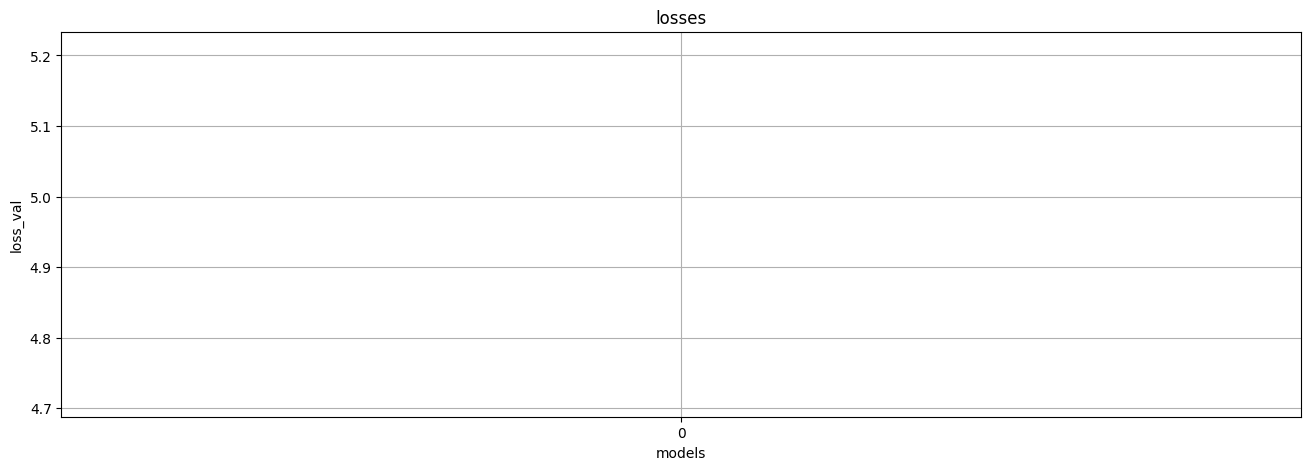

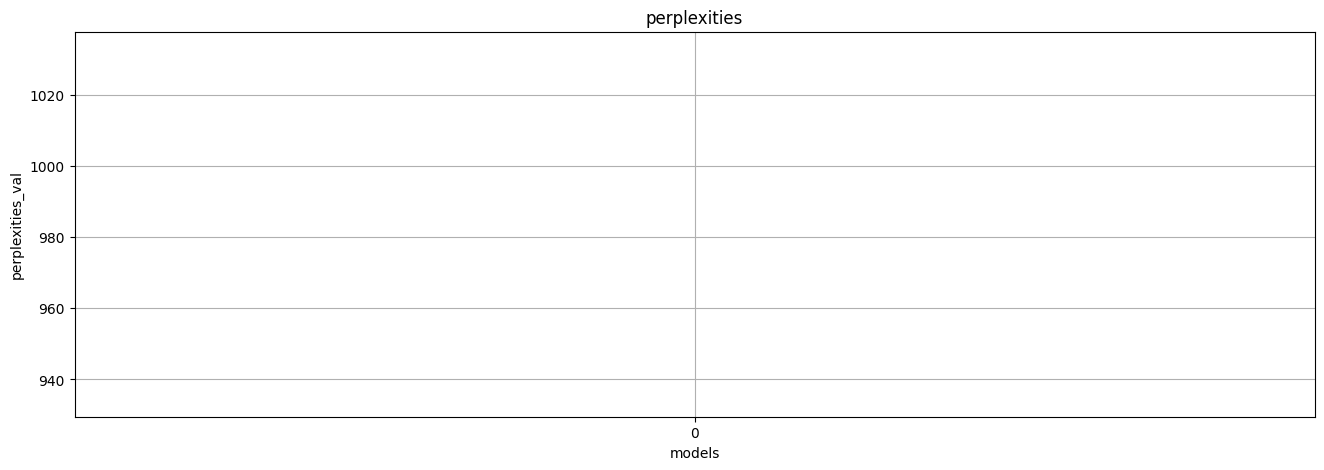

In [74]:
draw_end_losses_and_perplexities_for_claster(claster)

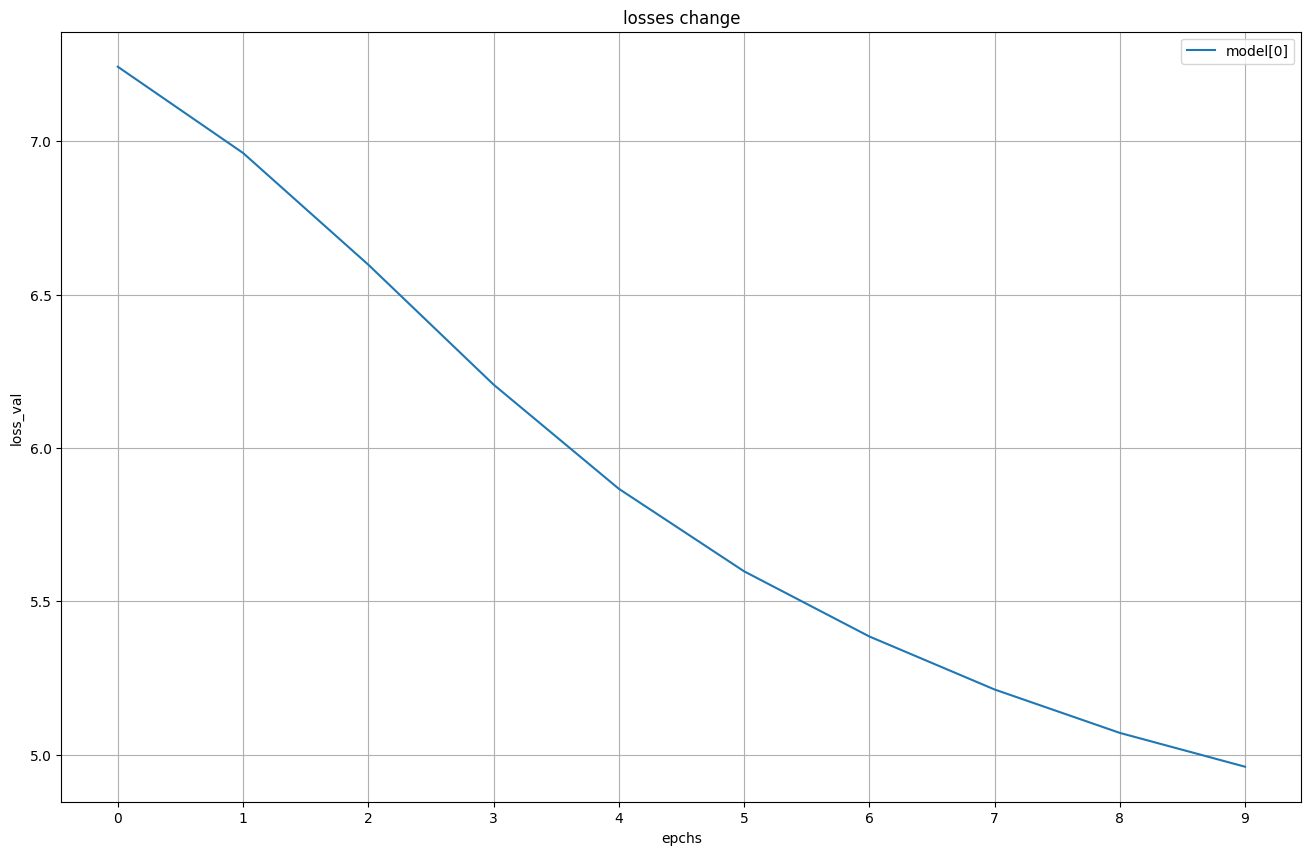

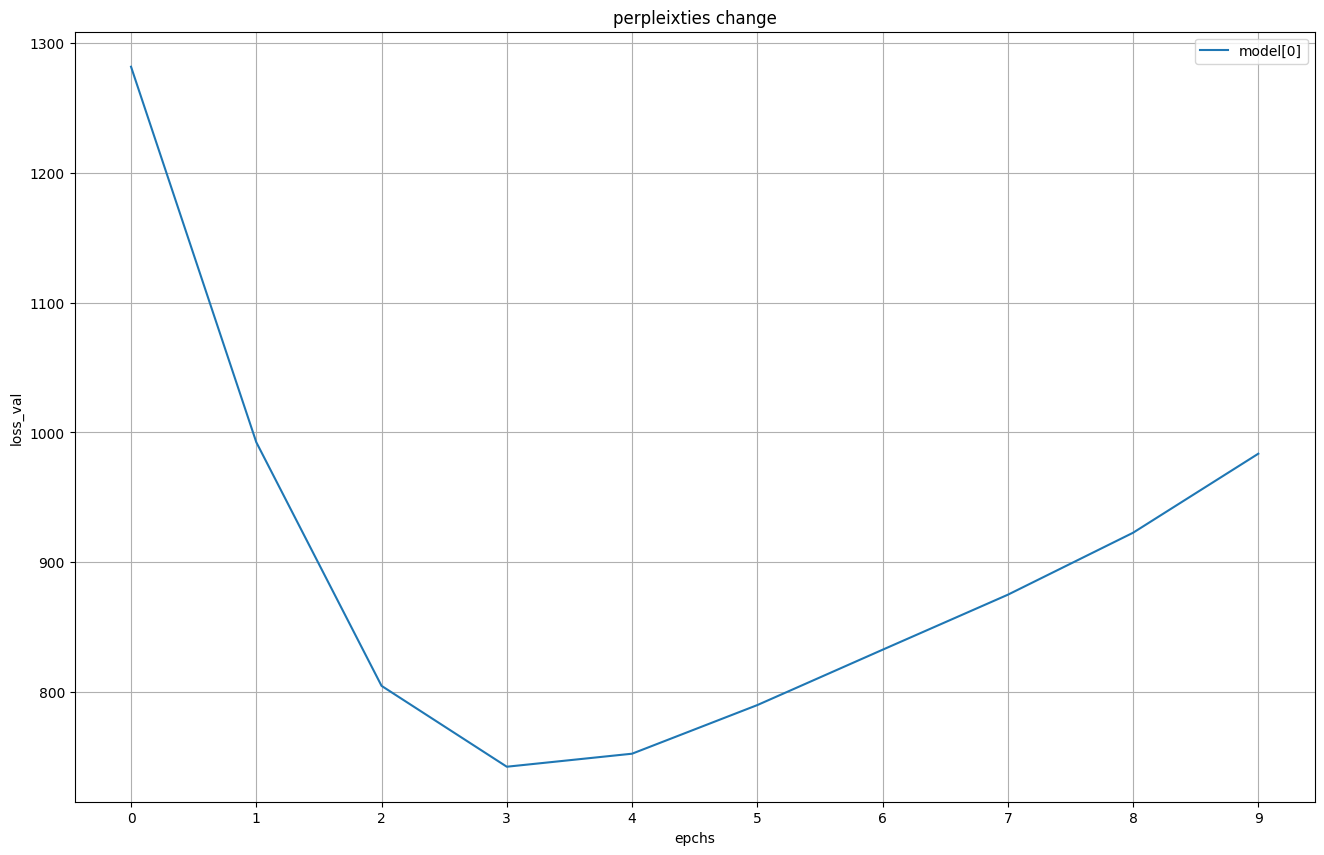

In [75]:
draw_all_losses_and_perplexities_for_claster(claster)

результат генерации различных моделей сомнительный, все работают плохо

## text generation func

In [76]:
def generate(model, start_s='жили у бабуси ', max_s_len=100, tokenizer=tokenizer, t2id=t2id, id2t=id2t):
    device = 'cuda'
    model.to(device)
    input_ids = [t2id['<bos>']] + [t2id.get(t, t2id['<unk>']) for t in tokenizer.encode(start_s).tokens]
    input_ids = torch.LongTensor(input_ids).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_s_len):
            next_t_vec = model(input_ids)
            next_t = next_t_vec.squeeze().argmax()

            input_ids = torch.cat([input_ids, next_t.unsqueeze(0).unsqueeze(0)], dim=1)
            # print(next_t.item(), input_ids)
            if next_t == t2id['<eos>']:
                break
    text = ''.join([id2t[ind.item()] for ind in input_ids[0]])
    return text
            

In [77]:
generate(claster[0][0],'и днем и ночью', 100)

'<bos>и днем и ночью                                                                                                    '